In [ ]:
#@title Load data
from google.colab import files
data = files.upload()

Saving cylinder_nektar_wake.mat to cylinder_nektar_wake.mat
Saving cylinder_nektar_t0_vorticity.mat to cylinder_nektar_t0_vorticity.mat


In [ ]:
#@title Data Framing
import tensorflow as tf
import numpy as np
from scipy.io import loadmat
import scipy.io

Re = tf.constant(100, dtype=tf.float64)

layers1 = [3, 40, 40, 40, 40, 40, 40, 40, 40, 40, 2]
layers2 = [3, 30, 30, 30, 30, 30, 30, 30, 2]

# Load Data
data = scipy.io.loadmat('/content/cylinder_nektar_wake.mat')

U_star = data['U_star'] # N x 2 x T
P_star = data['p_star'] # N x T
t_star = data['t'] # is the very last time frame
X_star = data['X_star'] # N x 2

N = X_star.shape[0] # total number of available data (Spatial) for training and test
T = t_star.shape[0] # total number of available data (Temporal) for training and test

# Rearrange Data (Total Data)
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
YY = np.tile(X_star[:,1:2], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

UU = U_star[:,0,:] # N x T
VV = U_star[:,1,:] # N x T
PP = P_star # N x T

x = XX.flatten()[:,None] # NT x 1
y = YY.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1

u = UU.flatten()[:,None] # NT x 1
v = VV.flatten()[:,None] # NT x 1
p = PP.flatten()[:,None] # NT x 1

# Training Data
N_train = 5000 # number of picked data for training
idx = np.random.choice(N*T, N_train, replace=False)
x_train = x[idx,:]
y_train = y[idx,:]
t_train = t[idx,:]
u_train = u[idx,:]
v_train = v[idx,:]
#p_train = p[idx,:]

data_train = tf.stack([x_train, y_train, t_train, u_train, v_train], axis = 1)
#data_train = tf.concat([x_train, y_train, t_train, u_train, v_train], axis = 1)

In [ ]:
#@title splite training data 2
# Define the conditions for splitting the data
condition1 = tf.logical_and(x_train >= 1, x_train <= 4.5) # left element
condition2 = tf.logical_and(x_train >= 4.5, x_train <= 8) # right element
condition3 = tf.logical_and(x_train >= 4.45, x_train <= 4.55) # Overlap zone
condition4 = tf.logical_and(y_train >= -2, y_train <= 2)

# Flatten the boolean masks to 1D arrays
condition1_flat = tf.reshape(condition1, [-1])
condition2_flat = tf.reshape(condition2, [-1])
condition3_flat = tf.reshape(condition3, [-1])
condition4_flat = tf.reshape(condition4, [-1])

# Create index arrays using the boolean masks
indices1 = tf.squeeze(tf.where(tf.logical_and(condition1_flat, condition4_flat)))
indices2 = tf.squeeze(tf.where(tf.logical_and(condition2_flat, condition4_flat)))
indices3 = tf.squeeze(tf.where(tf.logical_and(condition3_flat, condition4_flat)))

# Use the index arrays to extract the desired subsets of the data
data_train1 = tf.gather(data_train, indices1)
data_train2 = tf.gather(data_train, indices2)
data_train3 = tf.gather(data_train, indices3)

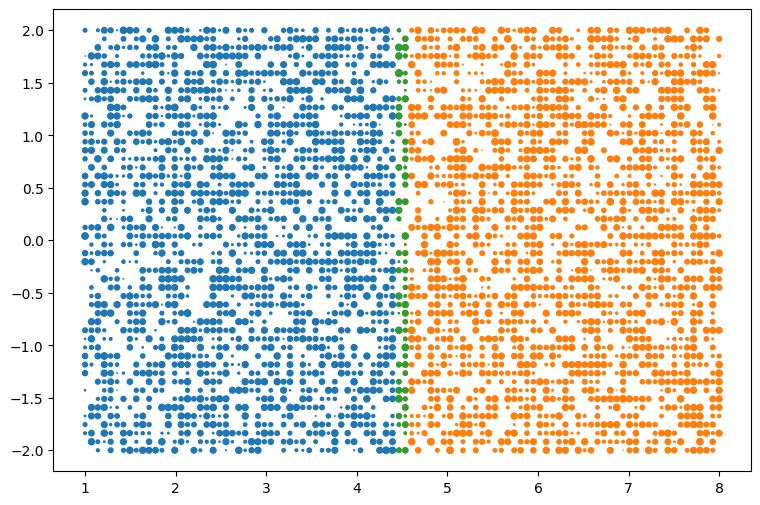

In [ ]:
#@title PLOT
import matplotlib.pyplot as plt

'''fig_1 = plt.figure(figsize=(9,6))
plt.scatter(x_train, y_train, t_train, u_train)

fig_2 = plt.figure(figsize=(9,6))
plt.scatter(x_train, y_train, t_train, v_train)'''

fig_3 = plt.figure(figsize=(9,6))
plt.scatter(data_train1[:,0], data_train1[:,1], data_train1[:,2])
plt.scatter(data_train2[:,0], data_train2[:,1], data_train2[:,2])
plt.scatter(data_train3[:,0], data_train3[:,1], data_train3[:,2])

In [ ]:
#@title NN
Mode_1 = 'M1'
Mode_2 = 'N1'
# Xavier initialization
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
    return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float64) * xavier_stddev,
                        dtype=tf.float64)

if Mode_2 in ['N2']:
            # Initialize encoder weights and biases
            encoder_weights_1 = xavier_init([2, layers[1]])
            encoder_biases_1 = xavier_init([1, layers[1]])

            encoder_weights_2 = xavier_init([2, layers[1]])
            encoder_biases_2 = xavier_init([1, layers[1]])

# Initialize network weights and biases using Xavier initialization
def initialize_NN(layers):
    weights = []
    biases = []
    num_layers = len(layers)
    for l in range(0, num_layers - 1):
        W = xavier_init(size=[layers[l], layers[l + 1]])
        b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float64), dtype=tf.float64)
        weights.append(W)
        biases.append(b)
    return weights, biases


weights1, biases1 = initialize_NN(layers1)
weights2, biases2 = initialize_NN(layers2)




# Evaluates the forward pass %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%% Network
def forward_pass(H, weights, biases):
    if Mode_2 in ['N1']:
        num_layers = len(weights) + 1
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

    if Mode_2 in ['N2']:
        num_layers = len(layers)
        encoder_1 = tf.tanh(tf.add(tf.matmul(H, encoder_weights_1), encoder_biases_1))
        encoder_2 = tf.tanh(tf.add(tf.matmul(H, encoder_weights_2), encoder_biases_2))

        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.math.multiply(tf.tanh(tf.add(tf.matmul(H, W), b)), encoder_1) + \
                tf.math.multiply(tf.tanh(tf.add(1 - tf.matmul(H, W), b)), encoder_2)

        W = weights[-1]
        b = biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H

In [ ]:
def operator(Data, w, b):
    # A tf.GradientTape is used to compute derivatives in TensorFlow
  with tf.GradientTape(persistent=True) as ggg:
      #x, y , t = X[:, 0:1], X[:,1:2], X[:,2:3]
      #x = tf.convert_to_tensor(x)
      #y = tf.convert_to_tensor(y)
      #t = tf.convert_to_tensor(t)
      x = Data[:,0]
      y = Data[:,1]
      t = Data[:,2]
      ggg.watch(x)
      ggg.watch(y)
      ggg.watch(t)
      with tf.GradientTape(persistent=True) as gg:
          gg.watch(x)
          gg.watch(y)
          gg.watch(t)
          with tf.GradientTape(persistent=True) as g:
              g.watch(x)
              g.watch(y)
              g.watch(t)
              psi_p = forward_pass(tf.stack([x[:,0], y[:,0], t[:,0]], axis=1), w, b)
              psi = psi_p[..., 0, tf.newaxis]
              p   = psi_p[..., 1, tf.newaxis]
          u   =  g.gradient(psi, y)
          v   = -g.gradient(psi, x)
          p_x =  g.gradient(p,   x)
          p_y =  g.gradient(p,   y)
          del g
      u_x = gg.gradient(u, x)
      u_y = gg.gradient(u, y)
      u_t = gg.gradient(u, t)
      v_x = gg.gradient(v, x)
      v_y = gg.gradient(v, y)
      v_t = gg.gradient(v, t)
      del gg
  u_xx = ggg.gradient(u_x, x)
  u_yy = ggg.gradient(u_y, y)
  v_xx = ggg.gradient(v_x, x)
  v_yy = ggg.gradient(v_y, y)
  del ggg

  Ru_momentum = u_t + u * u_x + v * u_y + p_x - (u_xx + u_yy) / Re
  Rv_momentum = v_t + u * v_x + v * v_y + p_y - (v_xx + v_yy) / Re
  vort = v_x - u_y # vorticity

  return Ru_momentum, Rv_momentum, u, v, psi, p, vort, p_x, p_y

In [ ]:
'''# Forward pass
def net_uv(X):
  Xt = tf.convert_to_tensor(X, dtype = tf.float32)
  with tf.GradientTape(persistent=True) as g:
    x, y, t = Xt[:, 0:1], Xt[:,1:2], Xt[:,2:3]
    g.watch(x)
    g.watch(y)
    psi_p = forward_pass(tf.stack([x[:,0], y[:,0], t[:,0]], axis=-1))
    psi = psi_p[..., 0, tf.newaxis]
    p   = psi_p[..., 1, tf.newaxis]
  u   =  g.gradient(psi, y)
  v   = -g.gradient(psi, x)

  return u, v'''

'# Forward pass \ndef net_uv(X):\n  Xt = tf.convert_to_tensor(X, dtype = tf.float32)\n  with tf.GradientTape(persistent=True) as g:\n    x, y, t = Xt[:, 0:1], Xt[:,1:2], Xt[:,2:3]\n    g.watch(x)\n    g.watch(y)\n    psi_p = forward_pass(tf.stack([x[:,0], y[:,0], t[:,0]], axis=-1))\n    psi = psi_p[..., 0, tf.newaxis]\n    p   = psi_p[..., 1, tf.newaxis]\n  u   =  g.gradient(psi, y)\n  v   = -g.gradient(psi, x)\n  \n  return u, v'

In [ ]:
#@title Loss function
Ws = [weights1, weights2]
Bs = [biases1, biases2]

def compute_loss():
  # Outputs: Inside domain
  Ru1, Rv1, u_app1, v_app1, _, _, _, _, _ = operator(data_train1, weights1, biases1)
  Ru2, Rv2, u_app2, v_app2, _, _, _, _, _ = operator(data_train2, weights2, biases2)
  # Outputs: interface
  Ru1_i, Rv1_i, u_app1_i, v_app1_i, psi_app1_i, p_app1_i, vort_app1_i, p_xi1, p_yi1 = operator(data_train3, weights1, biases1)
  Ru2_i, Rv2_i, u_app2_i, v_app2_i, psi_app2_i, p_app2_i, vort_app2_i, p_xi2, p_yi2 = operator(data_train3, weights2, biases2)
  # LOSS TERMS
  # 1- Res Loss
  loss_res1 = tf.reduce_mean(tf.square(Ru1) + (tf.square(Rv1)))
  loss_res2 = tf.reduce_mean(tf.square(Ru2) + (tf.square(Rv2)))
  # 1.1- Res Loss - interface
    #loss_res1_i = tf.reduce_mean(tf.square(Ru1_i) + (tf.square(Rv1_i)))
    #loss_res2_i = tf.reduce_mean(tf.square(Ru2_i) + (tf.square(Rv2_i)))

  # 2- Velocity Constraints
  loss_bcs1 = tf.reduce_mean(tf.square(u_app1 - data_train1[:,3]) + tf.square(v_app1 - data_train1[:,4]))
  loss_bcs2 = tf.reduce_mean(tf.square(u_app2 - data_train2[:,3]) + tf.square(v_app2 - data_train2[:,4]))

  # 3- Other interface Constraints
  #loss_dpsi1_i = tf.reduce_mean(tf.square(u_app1_i - data_train3[:,3]) + tf.square(v_app1_i - data_train3[:,4]))
  #loss_dpsi2_i = tf.reduce_mean(tf.square(u_app2_i - data_train3[:,3]) + tf.square(v_app2_i - data_train3[:,4]))
  #loss_dp_i = tf.reduce_mean(tf.square(p_xi1 - p_xi2) + tf.square(p_yi1 - p_yi2))
  loss_p_i = tf.reduce_mean(tf.square(p_app1_i - p_app2_i))
  #loss_psi_i = tf.reduce_mean(tf.square(psi_app1_i - psi_app2_i))
  #loss_vort_i = tf.reduce_mean(tf.square(vort_app1_i - vort_app2_i))
  #loss_intf1 = loss_p_i + loss_psi_i# + loss_dp_i
  #loss_intf2 = loss_dpsi2_i + loss_p_i + loss_psi_i# + loss_dp_i

  loss1 = loss_res1 + loss_bcs1 + loss_p_i
  loss2 = loss_res2 + loss_bcs2

  return loss1, loss2

The next function computes the gradient of the loss function $\phi_\theta$ with respect to the unknown variables in the model, also called `trainable_variables` in TensorFlow, i.e. $\nabla_\theta \phi_\theta$.
This is also done via a `GradientTape`, but now it keeps track of the parameters $\theta$ in our model, which can be accessed by `model.trainable_variables`.

In [ ]:
def get_grad():
  with tf.GradientTape(persistent=True) as tape:
    # This tape is for derivatives with respect to trainable variables of NN (weights & biases)
    tape.watch([*Ws, *Bs])
    loss1, loss2 = compute_loss()
  ge2 = tape.gradient(loss2, Ws[1]+Bs[1], unconnected_gradients=tf.UnconnectedGradients.ZERO)
  ge1 = tape.gradient(loss1, Ws[0]+Bs[0], unconnected_gradients=tf.UnconnectedGradients.ZERO)

  #g_res = tape.gradient(loss_res, model.trainable_variables)
  #g_bcs = tape.gradient(loss_bcs, model.trainable_variables)

  del tape

  return loss1, loss2, ge1, ge2

In [ ]:
#Optimizer setting
# We choose a piecewise decay of the learning rate, i.e., the
# step size in the gradient descent type algorithm
# the first 1000 steps use a learning rate of 0.01
# from 1000 - 3000: learning rate = 0.001
# from 3000 onwards: learning rate = 0.0005

#lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([7000, 14000, 35000], [1e-3, 1e-4, 1e-5, 1e-6])
lr = tf.keras.optimizers.schedules.PiecewiseConstantDecay([7000, 18000, 35000], [1e-3, 5e-4, 5e-5, 5e-6])
#starter_learning_rate = 1e-4
#lr = tf.keras.optimizers.schedules.ExponentialDecay(starter_learning_rate,
#                                                        decay_steps=1000, decay_rate=0.9, staircase=True)

optim1 = tf.keras.optimizers.Adam(learning_rate = lr)
optim2 = tf.keras.optimizers.Adam(learning_rate = lr)

Here, we set up a function `train_step()` which performs one training step.

*Note*: The `@tf.function` is a so-called `Decorator` within Python. This particular decorator redefines the function that follows, in our case `train_step`, as a TensorFlow graph which may speed up the training significantly.

In [ ]:
#@title Run
from time import time
# Define one training step as a TensorFlow function to increase speed of training
@tf.function
def train_step():
  # Compute current loss and gradient w.r.t. parameters
  loss1, loss2, ge1, ge2 = get_grad()
  #Do GD step
  optim2.apply_gradients(zip(ge2, Ws[1]+Bs[1]))
  optim1.apply_gradients(zip(ge1, Ws[0]+Bs[0]))

  return loss1, loss2, ge1, ge2

#Set number of training epochs
N_ep = 60000
hist1 = []
hist2 = []
hist3 = []

#start timer
t0 = time()

for i in range (N_ep+1):
  loss1, loss2, ge1, ge2  = train_step()



  #Append current loss to the hist
  hist1.append(loss1.numpy())
  hist2.append(loss2.numpy())
  #hist3.append(loss_intf.numpy())

  if i%50 == 0:
    print('It {:05d}, loss1 = {:10.6e}, loss2 = {:10.6e}' .format(i,loss1, loss2))
# Print computation time
print('\nComputation time: {} seconds' .format(time()-t0))

It 00000, loss1 = 1.149667e+00, loss2 = 8.254579e-01
It 00050, loss1 = 1.922485e-01, loss2 = 1.111941e-01
It 00100, loss1 = 1.266965e-01, loss2 = 9.313016e-02
It 00150, loss1 = 1.036700e-01, loss2 = 8.646629e-02
It 00200, loss1 = 9.453544e-02, loss2 = 7.522352e-02
It 00250, loss1 = 8.971154e-02, loss2 = 6.518120e-02
It 00300, loss1 = 8.582195e-02, loss2 = 5.799876e-02
It 00350, loss1 = 9.191701e-02, loss2 = 5.215737e-02
It 00400, loss1 = 7.793655e-02, loss2 = 4.839944e-02
It 00450, loss1 = 7.483443e-02, loss2 = 4.569188e-02
It 00500, loss1 = 7.236338e-02, loss2 = 4.288553e-02
It 00550, loss1 = 7.223949e-02, loss2 = 4.158797e-02
It 00600, loss1 = 6.930717e-02, loss2 = 3.895596e-02
It 00650, loss1 = 6.790382e-02, loss2 = 3.568566e-02
It 00700, loss1 = 6.838460e-02, loss2 = 3.853392e-02
It 00750, loss1 = 6.578423e-02, loss2 = 3.199220e-02
It 00800, loss1 = 6.454301e-02, loss2 = 3.025760e-02
It 00850, loss1 = 6.454118e-02, loss2 = 3.137605e-02
It 00900, loss1 = 6.277078e-02, loss2 = 2.6396

<ipython-input-11-ce8b28df18a1>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.semilogy(range(len(hist1)), hist1,'k-', c = 'b', label = 'loss 1')


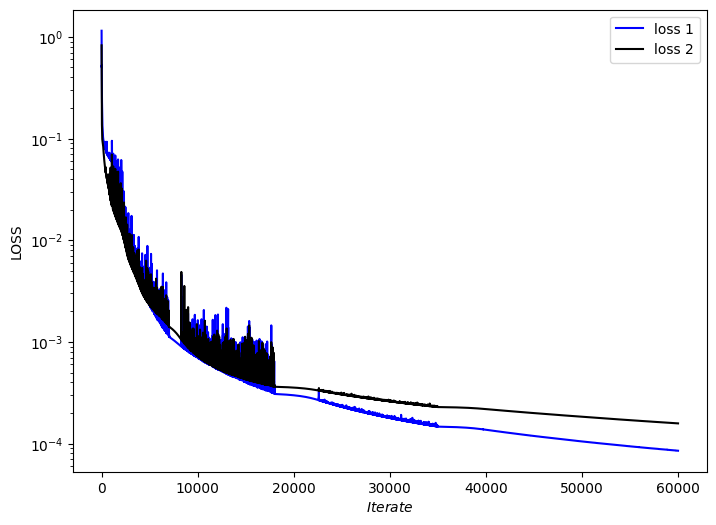

In [ ]:
#Loss Hist Plot
import numpy
import matplotlib.pyplot as plt
fig2 = plt.figure(figsize=(18,6))
ax = fig2.add_subplot(1,2,1)
ax.semilogy(range(len(hist1)), hist1,'k-', c = 'b', label = 'loss 1')
ax.semilogy(range(len(hist2)), hist2,'k-', label = 'loss 2')
#ax.semilogy(range(len(hist3)), hist3,'k-', c = 'r', label = 'loss-intf')
#ax.semilogy(range(len(hist4)), hist4,'k-', c = 'c', label = 'Pressure loss')
ax.set_xlabel('$Iterate$')
ax.set_ylabel('LOSS');
ax.legend(loc='upper right', frameon=True)
plt.savefig('Loss.png', bbox_inches='tight', dpi=600)

In [ ]:
#@title Results I
# create meshgrid coordinates (x, y) for test plots
from scipy.interpolate import griddata

# NOTE: "Snap" is the test data time frame and "t_star" is the approximation time frame, for comparison
# Test Data
snap = np.array([100]) # select time frame
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
t_star = TT[:,snap]

u_star = U_star[:,0,snap]
v_star = U_star[:,1,snap]
p_star = P_star[:,snap]
################################################################################# Split test data: START
data_star =  tf.stack([x_star, y_star, t_star, u_star, v_star, p_star], axis = 1)

# Define the conditions for splitting the data
condition1a = tf.logical_and(x_star >= 1, x_star <= 4.5) # left element
condition2a = tf.logical_and(x_star > 4.5, x_star <= 8) # right element
#condition3a = tf.logical_and(x_star >= 4.45, x_star <= 4.55) # Overlap zone
condition4a = tf.logical_and(y_star >= -2, y_star <= 2)

# Flatten the boolean masks to 1D arrays
condition1a_flat = tf.reshape(condition1a, [-1])
condition2a_flat = tf.reshape(condition2a, [-1])
#condition3a_flat = tf.reshape(condition3a, [-1])
condition4a_flat = tf.reshape(condition4a, [-1])

# Create index arrays using the boolean masks
indices1a = tf.squeeze(tf.where(tf.logical_and(condition1a_flat, condition4a_flat)))
indices2a = tf.squeeze(tf.where(tf.logical_and(condition2a_flat, condition4a_flat)))
#indices3a = tf.squeeze(tf.where(tf.logical_and(condition3a_flat, condition4a_flat)))

# Use the index arrays to extract the desired subsets of the data
data_star1 = tf.gather(data_star, indices1a)
data_star2 = tf.gather(data_star, indices2a)
#data_star3 = tf.gather(data_star, indices3a)

x_star1 = data_star1[:,0]
y_star1 = data_star1[:,1]
t_star1 = data_star1[:,2]
u_star1 = data_star1[:,3]
v_star1 = data_star1[:,4]
p_star1 = data_star1[:,5]
x_star2 = data_star2[:,0]
y_star2 = data_star2[:,1]
t_star2 = data_star2[:,2]
u_star2 = data_star2[:,3]
v_star2 = data_star2[:,4]
p_star2 = data_star2[:,5]
#x_star3 = data_star3[:,0]
#y_star3 = data_star3[:,1]
#t_star3 = data_star3[:,2]
#u_star3 = data_star3[:,3]
#v_star3 = data_star3[:,4]
#p_star3 = data_star3[:,5]

# Stich back
x_tot = np.concatenate([data_star1[:,0], data_star2[:,0]])
y_tot = np.concatenate([data_star1[:,1], data_star2[:,1]])

XY1 =  np.concatenate([x_star1, y_star1], axis = 1)
XY2 =  np.concatenate([x_star2, y_star2], axis = 1)
#XY3 =  np.concatenate([x_star3, y_star3], axis = 1)
XY_star = np.concatenate([XY1, XY2])
x_star =  np.concatenate([x_star1, x_star2])
y_star =  np.concatenate([y_star1, y_star2])
################################################################################# Split test data: END
def uv_grid(data, w, b):
  data1 = data[:,0:5,:]
  Ru_momentum, Rv_momentum, u, v, psi, p, vort, _, _ = operator(data1, w, b)
  return u.numpy(), v.numpy(), p.numpy(), vort.numpy()

# inside elements result
u_p1, v_p1, p_p1, vort_p1 = uv_grid(data_star1, weights1, biases1)
u_p2, v_p2, p_p2, vort_p2 = uv_grid(data_star2, weights2, biases2)

# Interface results
'''u_pi1, v_pi1, p_pi1, vort_pi1 = uv_grid(data_star3, weights1, biases1)
u_pi2, v_pi2, p_pi2, vort_pi2 = uv_grid(data_star3, weights2, biases2)
u_pi = (u_pi1 + u_pi2)/2
v_pi = (v_pi1 + v_pi2)/2
p_pi = (p_pi1 + p_pi2)/2
vort_pi = (vort_pi1 + vort_pi2)/2'''

u_tot = np.concatenate([u_p1, u_p2])
v_tot = np.concatenate([v_p1, v_p2])
#psi_tot = np.concatenate([psi1, psi2, psi3, psi4])
p_tot = np.concatenate([p_p1, p_p2])
vort_tot = np.concatenate([vort_p1, vort_p2])

U_tot = np.sqrt(u_tot**2 + v_tot**2)

#u_app = u.reshape(X.shape)
#v_app = v.reshape(Y.shape)

#u_star = np.sqrt(u_app**2 + v_app**2)
#U_star = griddata(X_star, u_star.flatten(), (X, Y), method='cubic')
# >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Reference
u_star =  np.concatenate([u_star1, u_star2])
v_star =  np.concatenate([v_star1, v_star2])
Vel_star = np.sqrt(u_star**2 + v_star**2)
p_star =  np.concatenate([p_star1, p_star2])
# Relative error
error_x = np.linalg.norm(u_star-u_tot,2)/np.linalg.norm(u_star,2)
error_y = np.linalg.norm(v_star-v_tot,2)/np.linalg.norm(v_star,2)
#error_U = np.linalg.norm(Vel_star-U_tot,2)/np.linalg.norm(Vel_star,2)
error_p1 = np.linalg.norm(p_star1-p_p1,2)/np.linalg.norm(p_star1,2)
error_p2 = np.linalg.norm(p_star2-p_p2,2)/np.linalg.norm(p_star2,2)
error_p = np.linalg.norm(p_star-p_tot,2)/np.linalg.norm(p_star,2)

print('l2 error-x: {:.2e}'.format(error_x))
print('l2 error-y: {:.2e}'.format(error_y))
#print('l2 error-U: {:.2e}'.format(error_U))
print('l2 error-p1: {:.2e}'.format(error_p1))
print('l2 error-p2: {:.2e}'.format(error_p2))
print('l2 error-p: {:.2e}'.format(error_p))

#>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> Plots

# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)

UU_ref = griddata(XY_star, u_star.flatten(), (X, Y), method='cubic') # X_star? or x_star, y_star, t_star
VV_ref = griddata(XY_star, v_star.flatten(), (X, Y), method='cubic')

UU_star = griddata(XY_star, u_tot.flatten(), (X, Y), method='cubic')
VV_star = griddata(XY_star, v_tot.flatten(), (X, Y), method='cubic')
PP_star = griddata(XY_star, p_tot.flatten(), (X, Y), method='cubic')
P_exact = griddata(XY_star, p_star.flatten(), (X, Y), method='cubic')

l2 error-x: 6.31e-03
l2 error-y: 2.12e-02
l2 error-p1: 2.34e-01
l2 error-p2: 4.62e-01
l2 error-p: 2.86e-01


<ipython-input-14-94fb49b5a90c>:21: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  modes = np.asscalar(data_vort['modes'])
<ipython-input-14-94fb49b5a90c>:22: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  nel = np.asscalar(data_vort['nel'])
<ipython-input-14-94fb49b5a90c>:37: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


Text(0.5, 1.0, 'Vorticity')

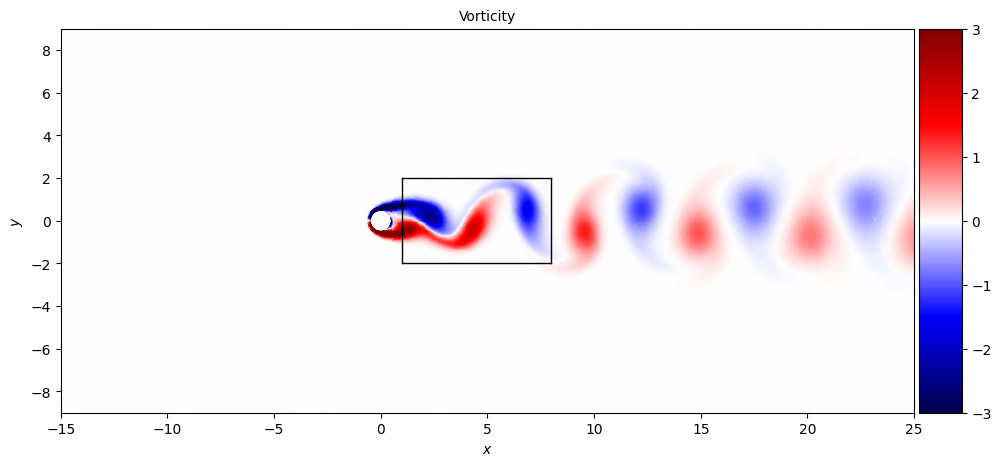

In [ ]:
#@title Results II
# Load Data
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

data_vort = scipy.io.loadmat('/content/cylinder_nektar_t0_vorticity.mat')

x_vort = data_vort['x']
y_vort = data_vort['y']
w_vort = data_vort['w']
modes = np.asscalar(data_vort['modes'])
nel = np.asscalar(data_vort['nel'])

xx_vort = np.reshape(x_vort, (modes+1,modes+1,nel), order = 'F')
yy_vort = np.reshape(y_vort, (modes+1,modes+1,nel), order = 'F')
ww_vort = np.reshape(w_vort, (modes+1,modes+1,nel), order = 'F')

box_lb = np.array([1.0, -2.0])
box_ub = np.array([8.0, 2.0])

fig = plt.figure(figsize=(10, 12))
ax = fig.add_subplot(111)
ax.axis('off')
####### Row 0: Vorticity ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-2/4 + 0.12, left=0.0, right=1.0, wspace=0)
ax = plt.subplot(gs0[:, :])

for i in range(0, nel):
    h = ax.pcolormesh(xx_vort[:,:,i], yy_vort[:,:,i], ww_vort[:,:,i], cmap='seismic',shading='gouraud',  vmin=-3, vmax=3)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot([box_lb[0],box_lb[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
ax.plot([box_ub[0],box_ub[0]],[box_lb[1],box_ub[1]],'k',linewidth = 1)
ax.plot([box_lb[0],box_ub[0]],[box_lb[1],box_lb[1]],'k',linewidth = 1)
ax.plot([box_lb[0],box_ub[0]],[box_ub[1],box_ub[1]],'k',linewidth = 1)

ax.set_aspect('equal', 'box')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_title('Vorticity', fontsize = 10)

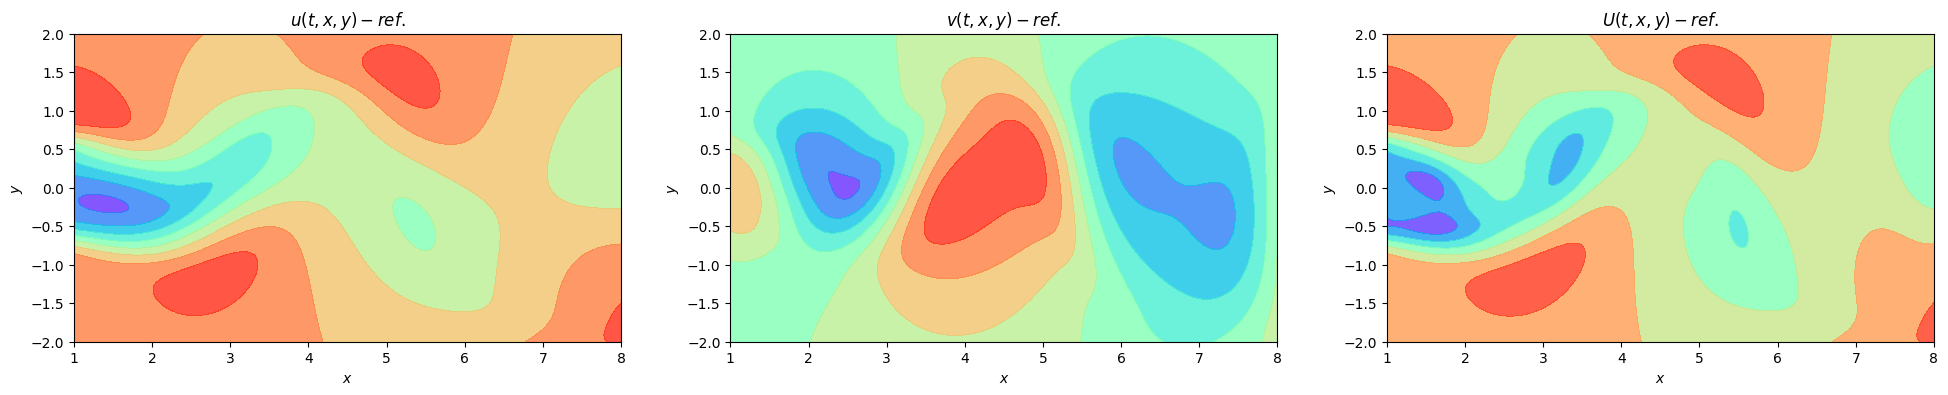

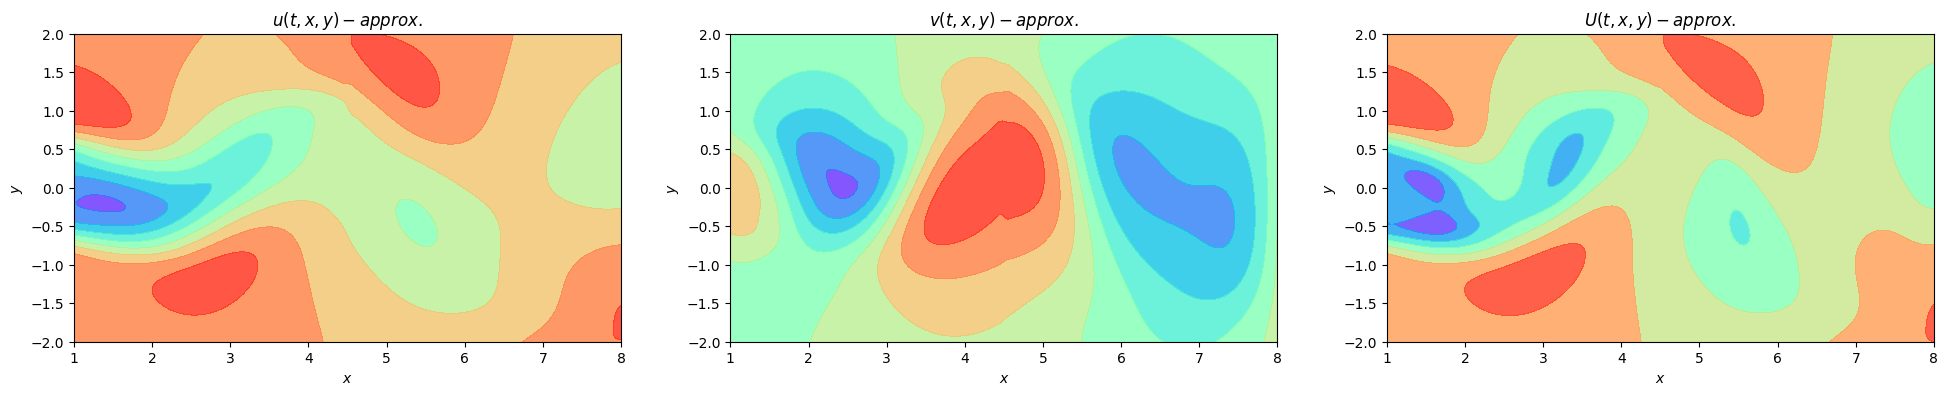

In [ ]:
#@title Velocity Contours - Compare
UV_ref = tf.sqrt((UU_ref)**2 + (VV_ref)**2)
UV_app = tf.sqrt((UU_star)**2 + (VV_star)**2)

figx1A = plt.figure(figsize=(24, 4))
# Plot the contour of u(t,x,y) - Reference Solution
ax1 = figx1A.add_subplot(131)
ax1.contourf(X, Y, UU_ref, cmap='rainbow', alpha=0.8)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('$u(t,x,y) - ref.$')

# Plot the contour of v(t,x,y) - Reference Solution
ax2 = figx1A.add_subplot(132)
ax2.contourf(X, Y, VV_ref, cmap='rainbow', alpha=0.8)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('$v(t,x,y) - ref.$')

# Plot the contour of u(t,x,y) - Reference
ax3 = figx1A.add_subplot(133)
ax3.contourf(X, Y, UV_ref, cmap='rainbow', alpha=0.8)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title('$U(t,x,y) - ref.$')

plt.savefig('velocity contur.png', bbox_inches='tight', dpi=600)
plt.show()

figx1B = plt.figure(figsize=(24, 4))
# Plot the contour of u(t,x,y) - Approximation
ax1 = figx1B.add_subplot(131)
ax1.contourf(X, Y, UU_star, cmap='rainbow', alpha=0.8)
ax1.set_xlabel('$x$')
ax1.set_ylabel('$y$')
ax1.set_title('$u(t,x,y) - approx.$')

# Plot the contour of v(t,x,y) - Approximation
ax2 = figx1B.add_subplot(132)
ax2.contourf(X, Y, VV_star, cmap='rainbow', alpha=0.8)
ax2.set_xlabel('$x$')
ax2.set_ylabel('$y$')
ax2.set_title('$v(t,x,y) - approx.$')
# Plot the contour of UV(t,x,y) - Approx
ax3 = figx1B.add_subplot(133)
ax3.contourf(X, Y, UV_app, cmap='rainbow', alpha=0.8)
ax3.set_xlabel('$x$')
ax3.set_ylabel('$y$')
ax3.set_title('$U(t,x,y) - approx.$')

# Show the plot
plt.savefig('velocity contur 2.png', bbox_inches='tight', dpi=600)
plt.show()

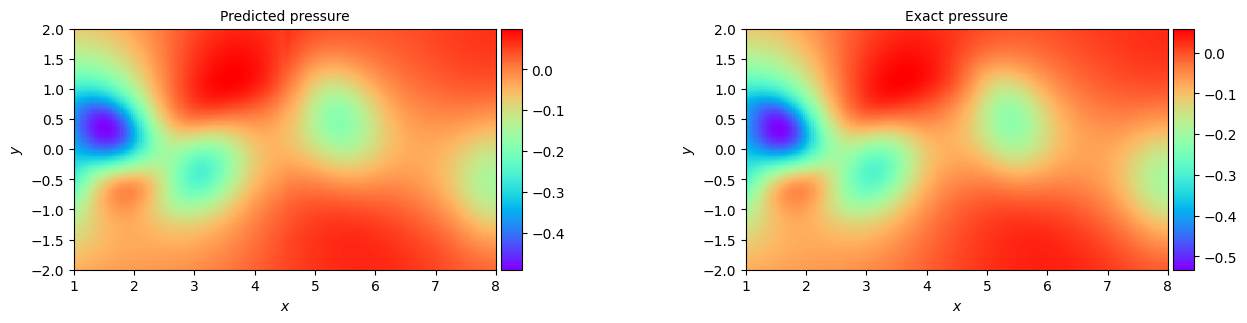

In [ ]:
######## Row 2: Pressure #######################
########      Predicted p(t,x,y)     ###########
fig = plt.figure(figsize=(14, 6))
gs2 = gridspec.GridSpec(1, 2)
gs2.update(top=1, bottom=1-1/2, left=0.1, right=0.9, wspace=0.5)
ax = plt.subplot(gs2[:, 0])
h = ax.imshow(PP_star, interpolation='nearest', cmap='rainbow',
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Predicted pressure', fontsize = 10)

########     Exact p(t,x,y)     ###########
ax = plt.subplot(gs2[:, 1])
h = ax.imshow(P_exact, interpolation='nearest', cmap='rainbow',
              extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

fig.colorbar(h, cax=cax)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal', 'box')
ax.set_title('Exact pressure', fontsize = 10)

plt.savefig('pressure contur.png', bbox_inches='tight', dpi=600)